Using device: cuda
GPU: NVIDIA GeForce RTX 3060

Checking dataset paths:
Train images: True - F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images\train
Train labels: True - F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\labels\train
Val images: True - F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images\val
Val labels: True - F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\labels\val
Found 18681 images in F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images\train
Found 1004 images in F:\skills-copilot-codespaces-vscode\thesis\rsuddataset\rsud20k\images\val

Dataset loaded:
  Classes (13): ['Dilarang Berhenti', 'Dilarang Parkir', 'Dilarang Masuk']... (showing first 3)
  Train samples: 18681
  Val samples: 1004

Creating ViT model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

f:\skills-copilot-codespaces-vscode\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HACKER\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


✓ ViT model created with 85,808,653 parameters

Starting ViT training for 20 epochs...
  Batch [50/584], Loss: 2.0639
  Batch [50/584], Loss: 2.0639
  Batch [100/584], Loss: 2.0705
  Batch [100/584], Loss: 2.0705
  Batch [150/584], Loss: 1.8783
  Batch [150/584], Loss: 1.8783
  Batch [200/584], Loss: 2.0579
  Batch [200/584], Loss: 2.0579
  Batch [250/584], Loss: 1.7958
  Batch [250/584], Loss: 1.7958
  Batch [300/584], Loss: 2.1410
  Batch [300/584], Loss: 2.1410
  Batch [350/584], Loss: 1.9629
  Batch [350/584], Loss: 1.9629
  Batch [400/584], Loss: 1.5789
  Batch [400/584], Loss: 1.5789
  Batch [450/584], Loss: 1.9809
  Batch [450/584], Loss: 1.9809
  Batch [500/584], Loss: 1.5532
  Batch [500/584], Loss: 1.5532
  Batch [550/584], Loss: 1.8372
  Batch [550/584], Loss: 1.8372
Epoch [1/20] (LR: 0.000099)
  Train Loss: 1.9067, Train Acc: 33.63%
  Val Loss: 2.0229, Val Acc: 25.70%
Epoch [1/20] (LR: 0.000099)
  Train Loss: 1.9067, Train Acc: 33.63%
  Val Loss: 2.0229, Val Acc: 25.70%
  ✓

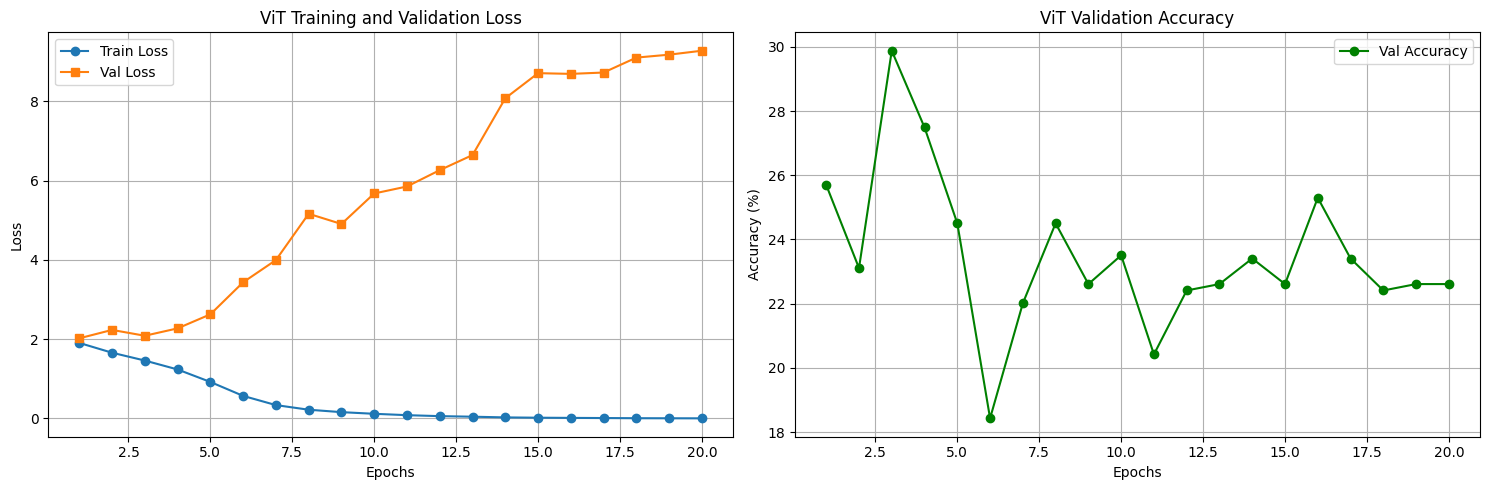


✓ ViT training complete! Run model_evu.ipynb to evaluate.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from timm import create_model
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import os

# GPU check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ------------------------
# Custom RSUD Dataset for ViT
# ------------------------
class RSUDDatasetViT(Dataset):
    """RSUD dataset for ViT classification training"""
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = Path(img_dir)
        self.label_dir = Path(label_dir)
        self.transform = transform
        
        # Get all image files
        self.image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
        
        # RSUD class names (13 classes)
        self.classes = [
            'Dilarang Berhenti', 'Dilarang Parkir', 'Dilarang Masuk',
            'Bahaya', 'Lampu Lalu Lintas Merah', 'Batas Kecepatan',
            'Wajib', 'Larangan Belok', 'Zona Pejalan Kaki',
            'Petunjuk Arah', 'Rambu Informasi', 'Hati-hati',
            'Zona Khusus'
        ]
        
        print(f"Found {len(self.image_files)} images in {img_dir}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = self.img_dir / img_name
        image = Image.open(img_path).convert('RGB')
        
        # Load label from YOLO format
        label_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = self.label_dir / label_name
        
        # Get first class label (for classification)
        label = 0  # default
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                first_line = f.readline().strip()
                if first_line:
                    label = int(first_line.split()[0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# ------------------------
# Dataset Setup - FIXED PATHS
# ------------------------
data_root = Path("F:/skills-copilot-codespaces-vscode/thesis/rsuddataset/rsud20k")
train_img_dir = data_root / "images" / "train"
train_label_dir = data_root / "labels" / "train"
val_img_dir = data_root / "images" / "val"
val_label_dir = data_root / "labels" / "val"

print(f"\nChecking dataset paths:")
print(f"Train images: {train_img_dir.exists()} - {train_img_dir}")
print(f"Train labels: {train_label_dir.exists()} - {train_label_dir}")
print(f"Val images: {val_img_dir.exists()} - {val_img_dir}")
print(f"Val labels: {val_label_dir.exists()} - {val_label_dir}")

batch_size = 32
img_size = 224

# ViT preprocessing (ImageNet normalization)
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = RSUDDatasetViT(train_img_dir, train_label_dir, transform=transform)
val_dataset = RSUDDatasetViT(val_img_dir, val_label_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

num_classes = len(train_dataset.classes)
print(f"\nDataset loaded:")
print(f"  Classes ({num_classes}): {train_dataset.classes[:3]}... (showing first 3)")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Val samples: {len(val_dataset)}")

# ------------------------
# ViT Model (timm)
# ------------------------
print("\nCreating ViT model...")
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
model = model.to(device)
print(f"✓ ViT model created with {sum(p.numel() for p in model.parameters()):,} parameters")

# ------------------------
# Loss & Optimizer
# ------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# ------------------------
# Output directory
# ------------------------
output_dir = Path("F:/skills-copilot-codespaces-vscode/thesis/checkpoints")
output_dir.mkdir(parents=True, exist_ok=True)

# ------------------------
# Training Loop
# ------------------------
num_epochs = 20
train_losses, val_losses, val_accs = [], [], []
best_val_acc = 0.0

print(f"\nStarting ViT training for {num_epochs} epochs...")
print("="*60)

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        if (batch_idx + 1) % 50 == 0:
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"Epoch [{epoch+1}/{num_epochs}] (LR: {current_lr:.6f})")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print("="*60)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), output_dir / "vit_best.pth")
        print(f"  ✓ Saved best model (Val Acc: {val_acc:.2f}%)")

# ------------------------
# Save final model
# ------------------------
torch.save(model.state_dict(), output_dir / "vit_final.pth")
print(f"\n✓ ViT training completed!")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Models saved to: {output_dir.absolute()}")

# ------------------------
# Plot training curves
# ------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
ax1.plot(range(1, num_epochs+1), val_losses, label="Val Loss", marker='s')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("ViT Training and Validation Loss")
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(range(1, num_epochs+1), val_accs, label="Val Accuracy", marker='o', color='green')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy (%)")
ax2.set_title("ViT Validation Accuracy")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(output_dir / "vit_training_curves.png", dpi=150)
print(f"  Training curves saved to: {output_dir / 'vit_training_curves.png'}")
plt.show()

print("\n" + "="*60)
print("✓ ViT training complete! Run model_evu.ipynb to evaluate.")
print("="*60)